In [1]:
from fastai.imports import *
from fastai.tabular import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from IPython.display import display

from sklearn import metrics

In [2]:
PATH = "C:/Users/dineshm2/fastai/data"

In [3]:
df_raw = pd.read_csv(f'{PATH}/Train.csv', low_memory=False, 
                     parse_dates=["saledate"])

In [4]:
df_raw.shape

(401125, 53)

In [5]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [6]:
df_raw.SalePrice = np.log(df_raw.SalePrice)

In [7]:
m = RandomForestRegressor(n_jobs=-1)

In [8]:
add_datepart(df_raw, 'saledate')
df_raw.saleYear.head()

0    2006
1    2004
2    2004
3    2011
4    2009
Name: saleYear, dtype: int64

In [9]:
def train_cats(df):
    for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()

In [10]:
train_cats(df_raw)

In [11]:
df_raw.UsageBand.cat.categories

Index(['High', 'Low', 'Medium'], dtype='object')

In [12]:
df_raw.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)

In [13]:
df_raw.UsageBand = df_raw.UsageBand.cat.codes

In [14]:
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

Backhoe_Mounting            0.803872
Blade_Extension             0.937129
Blade_Type                  0.800977
Blade_Width                 0.937129
Coupler                     0.466620
Coupler_System              0.891660
Differential_Type           0.826959
Drive_System                0.739829
Enclosure                   0.000810
Enclosure_Type              0.937129
Engine_Horsepower           0.937129
Forks                       0.521154
Grouser_Tracks              0.891899
Grouser_Type                0.752813
Hydraulics                  0.200823
Hydraulics_Flow             0.891899
MachineHoursCurrentMeter    0.644089
MachineID                   0.000000
ModelID                     0.000000
Pad_Type                    0.802720
Pattern_Changer             0.752651
ProductGroup                0.000000
ProductGroupDesc            0.000000
ProductSize                 0.525460
Pushblock                   0.937129
Ride_Control                0.629527
Ripper                      0.740388
S

In [15]:
def proc_df(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):
    if not ignore_flds: ignore_flds=[]
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    else: df = df.copy()
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    if preproc_fn: preproc_fn(df)
    if y_fld is None: y = None
    else:
        if not is_numeric_dtype(df[y_fld]): df[y_fld] = pd.Categorical(df[y_fld]).codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    else: na_dict = na_dict.copy()
    na_dict_initial = na_dict.copy()
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if len(na_dict_initial.keys()) > 0:
        df.drop([a + '_na' for a in list(set(na_dict.keys()) - set(na_dict_initial.keys()))], axis=1, inplace=True)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: res = res + [mapper]
    return res

In [16]:
def fix_missing(df, col, name, na_dict):
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict

In [17]:
def numericalize(df, col, name, max_n_cat):
    if not is_numeric_dtype(col) and ( max_n_cat is None or len(col.cat.categories)>max_n_cat):
        df[name] = pd.Categorical(col).codes+1

In [18]:
df, y, nas = proc_df(df_raw, 'SalePrice')

In [19]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(df, y)
m.score(df,y)

0.9831244500905013

In [20]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 12000  # same as Kaggle's test set size
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((389125, 66), (389125,), (12000, 66))

In [21]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [22]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 25.2 s
[0.09045654926033858, 0.24519708558393932, 0.9828992617892026, 0.8926310807366742]


# Speeding Things up

In [24]:
def get_sample(df,n):
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()

In [25]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice', subset=30000, na_dict=nas)
X_train, _ = split_vals(df_trn, 20000)
y_train, _ = split_vals(y_trn, 20000)

In [27]:
X_train.shape, y_train.shape

((20000, 66), (20000,))

In [28]:
m= RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train,y_train)
print_score(m)

Wall time: 959 ms
[0.11203396309625843, 0.359637325693962, 0.9727309749382288, 0.7690183427160465]


# Single Tree

In [44]:
from sklearn.tree import export_graphviz

In [35]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.5242727605214325, 0.5818746953859094, 0.4028481244979293, 0.3953460199119643]


# Bagging 

In [45]:
m= RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train,y_train)
print_score(m)

Wall time: 976 ms
[0.11366478923340696, 0.3736970469268447, 0.9719313118780205, 0.7506052506168259]


In [46]:
m.n_estimators

10

In [47]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0] 

(array([9.159047, 9.305651, 9.047821, 9.159047, 9.392662, 8.987197, 9.159047, 9.680344, 9.159047, 8.922658]),
 9.197252135479188,
 9.104979856318357)

In [48]:
X_valid.shape

(12000, 66)

In [49]:
preds.shape

(10, 12000)

In [52]:
np.mean(preds[:,11999]),y_valid[11999]

(9.532111383335257, 8.955448122347393)

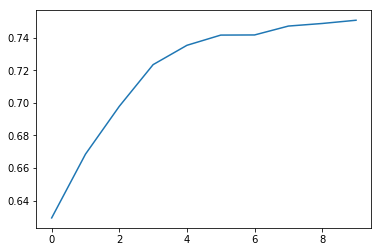

In [54]:
plt.plot([metrics.r2_score(y_valid,np.mean(preds[:i+1],axis=0)) for i in range(10)])

In [57]:
m = RandomForestRegressor(n_estimators=20, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.10202176746048201, 0.3578841819344988, 0.9773871188935088, 0.7712648117040555]


In [58]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.09661259334106267, 0.34511700213156565, 0.9797214128824621, 0.7872935377105803]


In [59]:
m = RandomForestRegressor(n_estimators=80, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.09468986716163028, 0.3481004973265833, 0.9805205259058577, 0.7835999974767852]


# Out-Of-Bag score 

In [60]:
m= RandomForestRegressor(n_estimators=40,n_jobs=-1,oob_score=True)
m.fit(X_train,y_train)
print_score(m)

[0.09636926080230197, 0.34722123373059255, 0.9798234332479495, 0.7846918220616803, 0.8552305370998636]


# Techniques to reduce overfitting

SubSampling

In [64]:
from sklearn.ensemble import forest

In [61]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

In [62]:
def set_rf_samples(n):
    """ Changes Scikit learn's random forests to give each tree a random sample of
    n random rows.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n))

In [65]:
set_rf_samples(20000)

In [66]:
m = RandomForestRegressor(n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 5.46 s
[0.24000166135985124, 0.28014665933450394, 0.8796175099744611, 0.8598416842653962, 0.8670369470144113]


In [67]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.22720230232388056, 0.26228880550182615, 0.892115194748327, 0.8771408561638668, 0.8806204856354775]


In [68]:
def reset_rf_samples():
    """ Undoes the changes produced by set_rf_samples.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n_samples))

Tree building parameters

In [70]:
reset_rf_samples()

In [71]:
def dectree_max_depth(tree):
    children_left = tree.children_left
    children_right = tree.children_right

    def walk(node_id):
        if (children_left[node_id] != children_right[node_id]):
            left_max = 1 + walk(children_left[node_id])
            right_max = 1 + walk(children_right[node_id])
            return max(left_max, right_max)
        else: # leaf
            return 1

    root_node_id = 0
    return walk(root_node_id)

In [72]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.0782388588350178, 0.2361886122316162, 0.9872067808113429, 0.9003755623897363, 0.9086729279081671]


In [73]:
t=m.estimators_[0].tree_

In [75]:
dectree_max_depth(t)

46

In [76]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.1406293472515128, 0.23430041431700308, 0.958667968856238, 0.901962080325635, 0.9071059439957947]


In [78]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.11917974269765648, 0.22817631573669345, 0.9703148181981751, 0.9070200943904444, 0.9116595899617916]
